#SteamVis

Welcome to my Steam game visualization notebook! This notebook loads the data collected as output from GetGameData, cleans it, and visualizes it.

In [1]:
%matplotlib inline

from bs4 import BeautifulSoup
import datetime
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import time

In [2]:
with open('game_data_sample.json', 'r') as f:
    game_dict = json.load(f);

In [3]:
all_tags = [];
for appnumber in game_dict:
    for tag in game_dict[appnumber]['tags']:
        heading = 'tag_%s' % tag;
        if heading not in all_tags:
            all_tags.append(heading);

all_tags = sorted(all_tags)
#print len(all_tags)
#print all_tags

In [4]:
game_dict_list = [];

for appnumber in game_dict:
    game = game_dict[appnumber];
    
    new_dict = {};
    new_dict['appnumber'] = int(appnumber);
    for key in game:
        new_dict[key] = game[key];
    
    new_dict['release_date'] = pd.Timestamp(datetime.date(game['release_year'],
                                                          game['release_month'],
                                                          game['release_day']));
    new_dict.pop('release_year', None);
    new_dict.pop('release_month', None);
    new_dict.pop('release_day', None);
    
    for rank, tag in enumerate(game['tags']):
        new_dict['tag_%s' % tag] = rank + 1;
    new_dict.pop('tags', None);
    
    game_dict_list.append(new_dict);

In [5]:
game_df = pd.DataFrame(game_dict_list);
game_df.head()

,appnumber,game_name,good_review_percentage,good_review_percentage_recent,lifetime,metascore,n_reviews,n_reviews_recent,platform_linux,platform_mac,...,tag_Walking Simulator,tag_War,tag_Wargame,tag_Warhammer 40K,tag_Werewolves,tag_Western,tag_World War I,tag_World War II,tag_Zombies,tag_e-sports
0,34900,Bad Rats: the Rats' Revenge,76,92,2714,-1,12510,688,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,65090,Kaptain Brawe: A Brawe New World,73,-1,2165,69,92,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1200,Red Orchestra: Ostfront 41-45,89,90,3938,81,1222,30,1,1,...,NaN,14,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
3,61510,Age of Wonders II: The Wizard's Throne,76,-1,0,86,76,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23440,Europa Universalis: Rome - Gold Edition,66,-1,2957,79,101,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
game_df[all_tags] = game_df[all_tags].fillna(0);
game_df.head()

,appnumber,game_name,good_review_percentage,good_review_percentage_recent,lifetime,metascore,n_reviews,n_reviews_recent,platform_linux,platform_mac,...,tag_Walking Simulator,tag_War,tag_Wargame,tag_Warhammer 40K,tag_Werewolves,tag_Western,tag_World War I,tag_World War II,tag_Zombies,tag_e-sports
0,34900,Bad Rats: the Rats' Revenge,76,92,2714,-1,12510,688,0,0,...,0,0,0,0,0,0,0,0,0,0
1,65090,Kaptain Brawe: A Brawe New World,73,-1,2165,69,92,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1200,Red Orchestra: Ostfront 41-45,89,90,3938,81,1222,30,1,1,...,0,14,0,0,0,0,0,2,0,0
3,61510,Age of Wonders II: The Wizard's Throne,76,-1,0,86,76,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23440,Europa Universalis: Rome - Gold Edition,66,-1,2957,79,101,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
def steamvis(gamedf):
    mask = gamedf['tag_FPS'] > 5
    plotdf = gamedf[mask]
    plt.figure(figsize=(8,8));
    plt.scatter(plotdf['good_review_percentage'], plotdf['metascore'])
    plt.xlim(-5, 105);
    plt.ylim(-5, 105);
    plt.xlabel('Positive User Review Percentage');
    plt.ylabel('Metacritic Score');

In [46]:
def tag_not(df, tag):
    if tag not in df.columns:
        heading = 'tag_%s' % tag;
        
        if heading not in df.columns:
            print("%s is not a valid tag. Returning all True." % tag);
            return [True] * len(df.index);
        
        return df[heading] == 0;
    
    return df[tag] == 0;

In [90]:
def tag_most_like(df, tag, rank = 5):
    if tag not in df.columns:
        heading = 'tag_%s' % tag;
        
        if heading not in df.columns:
            print("%s is not a valid tag. Returning all True." % tag);
            return [True] * len(df.index);
        
        return ((df[heading] <= rank) & ~tag_not(df, heading));
    
    return ((df[tag] <= rank) & ~tag_not(df, tag));

In [91]:
def tag_most_unlike(df, tag, rank = 5):
    if tag not in df.columns:
        heading = 'tag_%s' % tag;
        
        if heading not in df.columns:
            print("%s is not a valid tag. Returning all True." % tag);
            return [True] * len(df.index);
        
        return ((df[heading] >= rank) | tag_not(df, heading));
    
    return ((df[tag] >= rank) | tag_not(df, tag));

In [92]:
def tag_is_but_unlike(df, tag, rank = 5):
    if tag not in df.columns:
        heading = 'tag_%s' % tag;
        
        if heading not in df.columns:
            print("%s is not a valid tag. Returning all True." % tag);
            return [True] * len(df.index);
        
        return (df[heading] >= rank);
    
    return (df[tag] >= rank);

In [93]:
def tag_is_between(df, tag, rankhigh = 5, ranklow = 10):
    if tag not in df.columns:
        heading = 'tag_%s' % tag;
        
        if heading not in df.columns:
            print("%s is not a valid tag. Returning all True." % tag);
            return [True] * len(df.index);
        
        return ((df[heading] >= rankhigh) & (df[heading] <= ranklow));
    
    return ((df[tag] >= rankhigh) & (df[tag] <= ranklow));

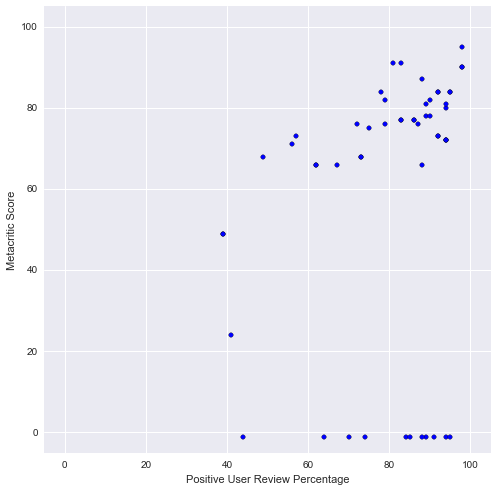

In [18]:
steamvis(game_df)

In [105]:
game_df[tag_is_but_unlike(game_df, 'tag_World War II', 4)]

,appnumber,game_name,good_review_percentage,good_review_percentage_recent,lifetime,metascore,n_reviews,n_reviews_recent,platform_linux,platform_mac,...,tag_Walking Simulator,tag_War,tag_Wargame,tag_Warhammer 40K,tag_Werewolves,tag_Western,tag_World War I,tag_World War II,tag_Zombies,tag_e-sports
76,6800,Commandos: Behind Enemy Lines,86,88,6693,-1,1007,96,0,0,...,0,0,0,0,0,0,0,4,0,0
163,2270,Wolfenstein 3D,94,98,8179,-1,1128,57,0,0,...,0,0,0,0,0,0,0,4,0,0
240,108210,Memoir '44 Online,65,-1,1900,-1,229,0,0,0,...,0,0,0,0,0,0,0,6,0,0
279,16720,Velvet Assassin,59,64,2794,61,1691,17,0,1,...,0,0,0,0,0,0,0,5,0,0
297,70000,Dino D-Day,84,92,2087,53,12530,263,0,0,...,0,9,0,0,0,0,0,4,0,0
302,9340,Company of Heroes: Opposing Fronts,93,-1,3376,87,459,0,0,0,...,0,0,0,0,0,0,0,4,0,0
610,9010,Return to Castle Wolfenstein,93,99,5513,88,1663,109,0,0,...,0,0,0,0,0,0,0,4,16,0
629,6250,Making History: The Calm & the Storm,83,-1,3574,70,474,0,0,0,...,0,0,0,0,0,0,0,5,0,0
742,9000,Spear of Destiny,85,-1,8476,-1,129,0,0,0,...,0,0,0,0,0,0,0,4,0,0
850,6260,Making History: The Calm & the Storm,83,-1,3574,70,474,0,0,0,...,0,0,0,0,0,0,0,5,0,0
